In [47]:
import numpy as np 
import pandas as pd 
import random 
import os 
from tqdm.auto import tqdm 
import time 
import datetime 
from torch.utils.data import * 
from transformers import * 
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from scipy.spatial.distance import cdist 
import logging
import re 

import json 
import ccxt 
from tqdm.auto import tqdm 
import pandas_ta as ta 
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec 
from mpl_finance import candlestick_ohlc

'''
plt.rcParams["font.family"] = "NanumGothic" #"Malgun Gothic" 
plt.rcParams["axes.unicode_minus"] = False 
''' 

def set_global_logging_level(level=logging.ERROR, prefices=[""]): 
    prefix_re = re.compile(fr'^(?:{ "|".join(prefices) })') 
    for name in logging.root.manager.loggerDict: 
        if re.match(prefix_re, name): 
            logging.getLogger(name).setLevel(level) 
            
set_global_logging_level(logging.ERROR, ["transformers", "nlp", "torch", "tensorflow", "tensorboard", "wandb"]) 

##### chart data ##### 
with open("BTC_USDT-1h-9.json") as f:
    d = json.load(f) 
    
chart_df = pd.DataFrame(d) 
chart_df = chart_df.rename(columns={0:"timestamp",
                                    1:"open",
                                    2:"high",
                                    3:"low",
                                    4:"close",
                                    5:"volume"}) 

def process(df): 
    binance = ccxt.binance() 
    dates = df["timestamp"].values 
    timestamp = [] 
    for i in range(len(dates)):  
        date_string = binance.iso8601(int(dates[i])) 
        date_string = date_string[:10] + " " + date_string[11:-5] 
        timestamp.append(date_string) 
    df["datetime"] = timestamp 
    df = df.drop(columns={"timestamp"}) 
    return df 

chart_df = process(chart_df) 

minutes, hours, days, months, years = [], [], [], [], [] 

for dt in tqdm(chart_df["datetime"], position=0, leave=True): 
    minute = pd.to_datetime(dt).minute 
    hour = pd.to_datetime(dt).hour 
    day = pd.to_datetime(dt).day 
    month = pd.to_datetime(dt).month 
    year = pd.to_datetime(dt).year 
    minutes.append(minute) 
    hours.append(hour) 
    days.append(day) 
    months.append(month) 
    years.append(year) 

chart_df["minutes"] = minutes 
chart_df["hours"] = hours 
chart_df["days"] = days 
chart_df["months"] = months 
chart_df["years"] = years 

open_vals = chart_df["open"].values 
high_vals = chart_df["high"].values 
low_vals = chart_df["low"].values 
close_vals = chart_df["close"].values 
volume = chart_df["volume"].values 
datetimes = chart_df["datetime"].values 
chart_minutes = chart_df["minutes"].values 
chart_hours = chart_df["hours"].values 
chart_days = chart_df["days"].values 
chart_months = chart_df["months"].values 
chart_years = chart_df["years"].values 

##### news data ##### 
df = pd.read_csv("full_news_october_1st.csv")
titles = df["titles"].values 
contents = df["contents"].values 
years = df["year"].values 
months = df["month"].values 
days = df["day"].values 
hours = df["hour"].values 

candidates = torch.load("news_candidate_embeddings.pt") # load candidate embedings 
tokenizer = AlbertTokenizer.from_pretrained("totoro4007/cryptodeberta-base-all-finetuned")
embedding_model = AutoModel.from_pretrained("totoro4007/cryptodeberta-base-all-finetuned") 
sentiment_model = AutoModelForSequenceClassification.from_pretrained("totoro4007/cryptodeberta-base-all-finetuned")   

def get_embeddings(title, content):  
    embedding_model.eval() 
    encoded_inputs = tokenizer(title, content, max_length=512, padding="max_length", truncation=True, return_tensors="pt") 
    with torch.no_grad(): 
        embedding = embedding_model(**encoded_inputs)[0][:,0,:] 
    return embedding 

def get_sentiment_score(title, content): 
    sentiment_model.eval() 
    encoded_inputs = tokenizer(title, content, max_length=512, padding="max_length", truncation=True, return_tensors="pt") 
    with torch.no_grad(): 
        sentiment = sentiment_model(**encoded_inputs)[0] 
        sentiment = nn.Softmax(dim=1)(sentiment)[0]
    return sentiment 


  0%|          | 0/46527 [00:00<?, ?it/s]

104826개의 DB에 저장된 후보 뉴스중 쿼리 코인니스 뉴스와 가장 유사한 top 10개의 코인니스 뉴스를 유사도 기반으로 랭킹해서 보여줍니다.
============================== query ==============================
법원 "비트코인도 몰수 가능"…암호화폐 경제적 가치 첫 인정
범죄에 쓰인 암호화폐가 몰수의 대상이 될 수 있다는 법원의 판결이 처음으로 나왔다. 그동안 물리적 실체가 있는 대상에 한정됐던 몰수가 전자파일 형태의 암호화폐로까지 확대됐다는 점에서 관심이 주목된다. 수원지법 형사항소8부(하성원 부장판사)는 30일 불법 음란물 사이트를 운영하며 회원들에게 이용료로 비트코인을 받은 혐의로 기소된 안모(33)씨에 대한 항소심 선고에서 원심을 깨고 "범죄수익으로 얻은 191 비트코인을 몰수하고, 7억여원을 추징하라"고 판결했다. 이날 오후 5시 30분, 현재 시세 기준으로 비트코인은 1258만원으로, 몰수 비트코인의 시가는 약 24억원에 달한다. 항소심 재판부는 "범죄수익 은닉의 규제 및 처벌 등에 관한 법률은 은닉 재산을 물건에 한정하지 않고 현금, 예금, 주식, 그 밖에 재산적 가치가 있는 유무형의 재산으로 본다"며 "비트코인은 물리적 실체없이 전자화한 파일 형태이지만, 거래소를 통해 거래되고 재화와 용역을 구매할 수 있어 수익에 해당한다"고 설명했다. 또 항소심 재판부는 "피고인은 음란물 사이트 회원 등에게 비트코인의 전자주소를 알려줘 전달받았다"며 "이런 기록은 압수된 비트코인에도 남아있어서 결국 사이트 운영으로 올린 수익으로 볼 수 있다"고 판시했다. 앞서 1심 재판부는 비트코인 가운데 일부는 사건과 무관한 것으로 볼 여지가 있고, 물리적 실체 없이 전자화한 파일 형태인 비트코인을 몰수하는 것은 적절치 않다며 검찰의 몰수 구형을 받아들이지 않았다. 하지만 이번에 항소심 재판부가 원심을 뒤집으면서 범죄에 쓰인 암호화폐에 대해 몰수 결정을 내린 첫 판결이 나왔다. 이로써 향후 암호화폐 관련 범죄에 영향을

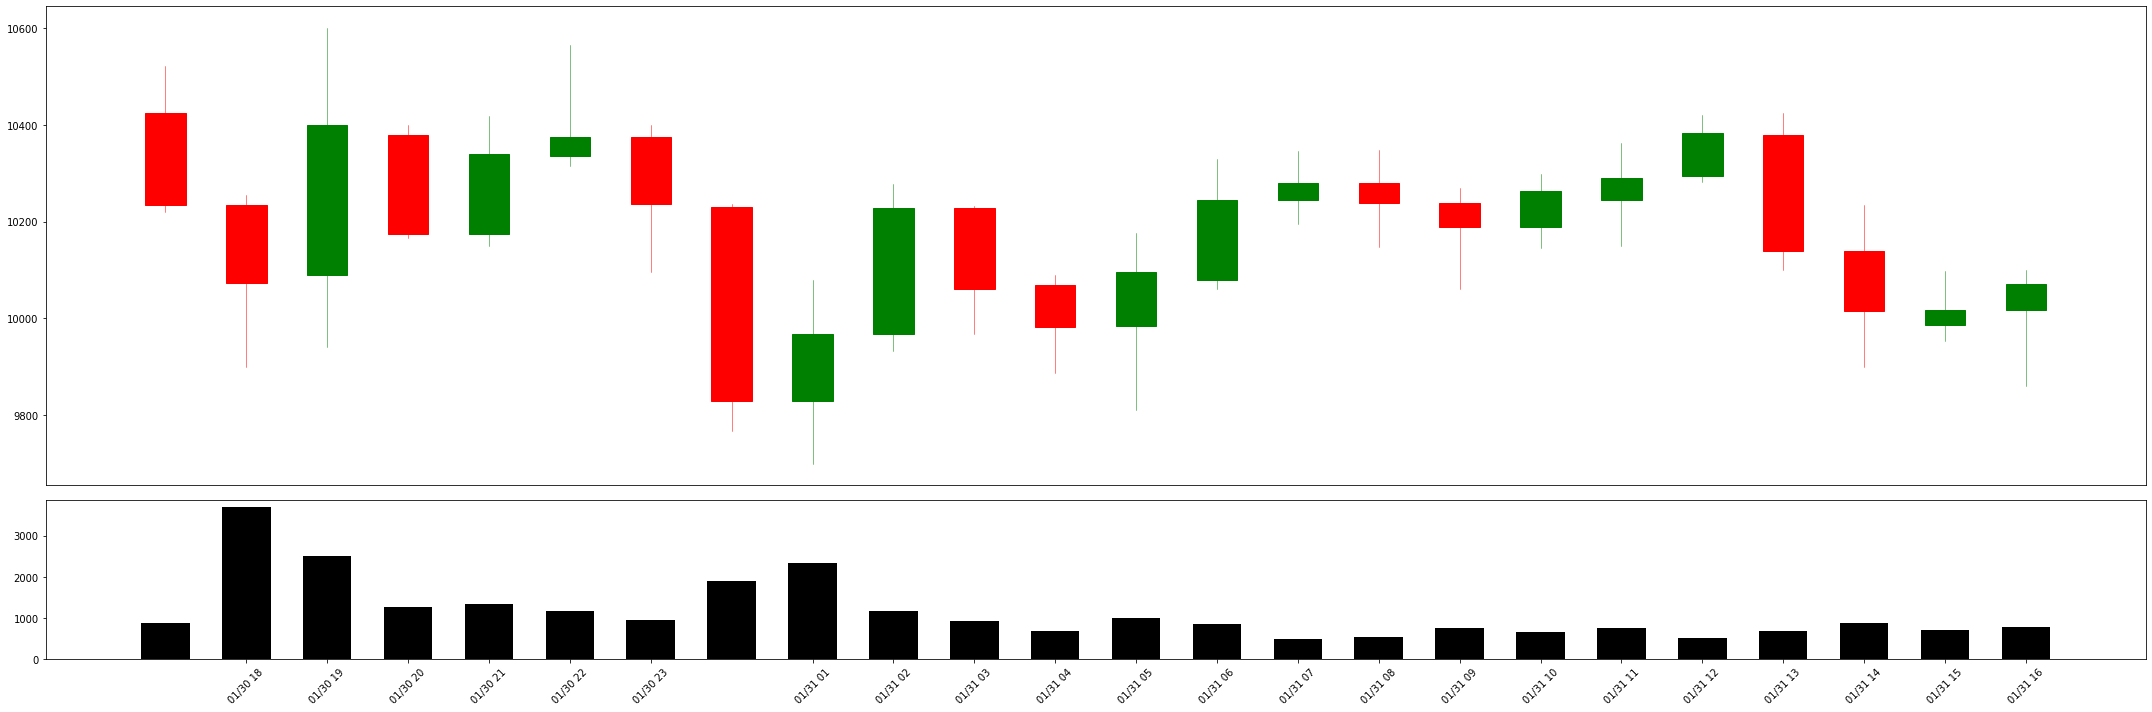






============================== candidates ==============================
싱가포르 고등법원 "암호화폐, 재산 인정" 첫 판결
싱가포르 고등법원이 처음으로 암호화폐를 재산(property)으로 인정하는 판결을 내렸다고 크립토뉴스가 전했다. 700만달러 상당 암호화폐 도난 사건에서 법원은 도난당한 암호화폐를 재산으로 간주하고, 이를 보관한 거래소 2곳에 범죄 추적을 위한 자료 제출을 명령했다. 법률 전문가들은 이러한 법원 명령이 고객 암호화폐 거래 정보에 대한 거래소의 기밀유지 의무를 무효화하는 데 효과적일 것이라고 내다봤다.
뉴스가 올라온 시각 : 2022년 3월 24일 10시 
딥러닝 기반 기사 유사도: 0.7371
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:86.13%, 악재:0.85%, 중립:13.03%


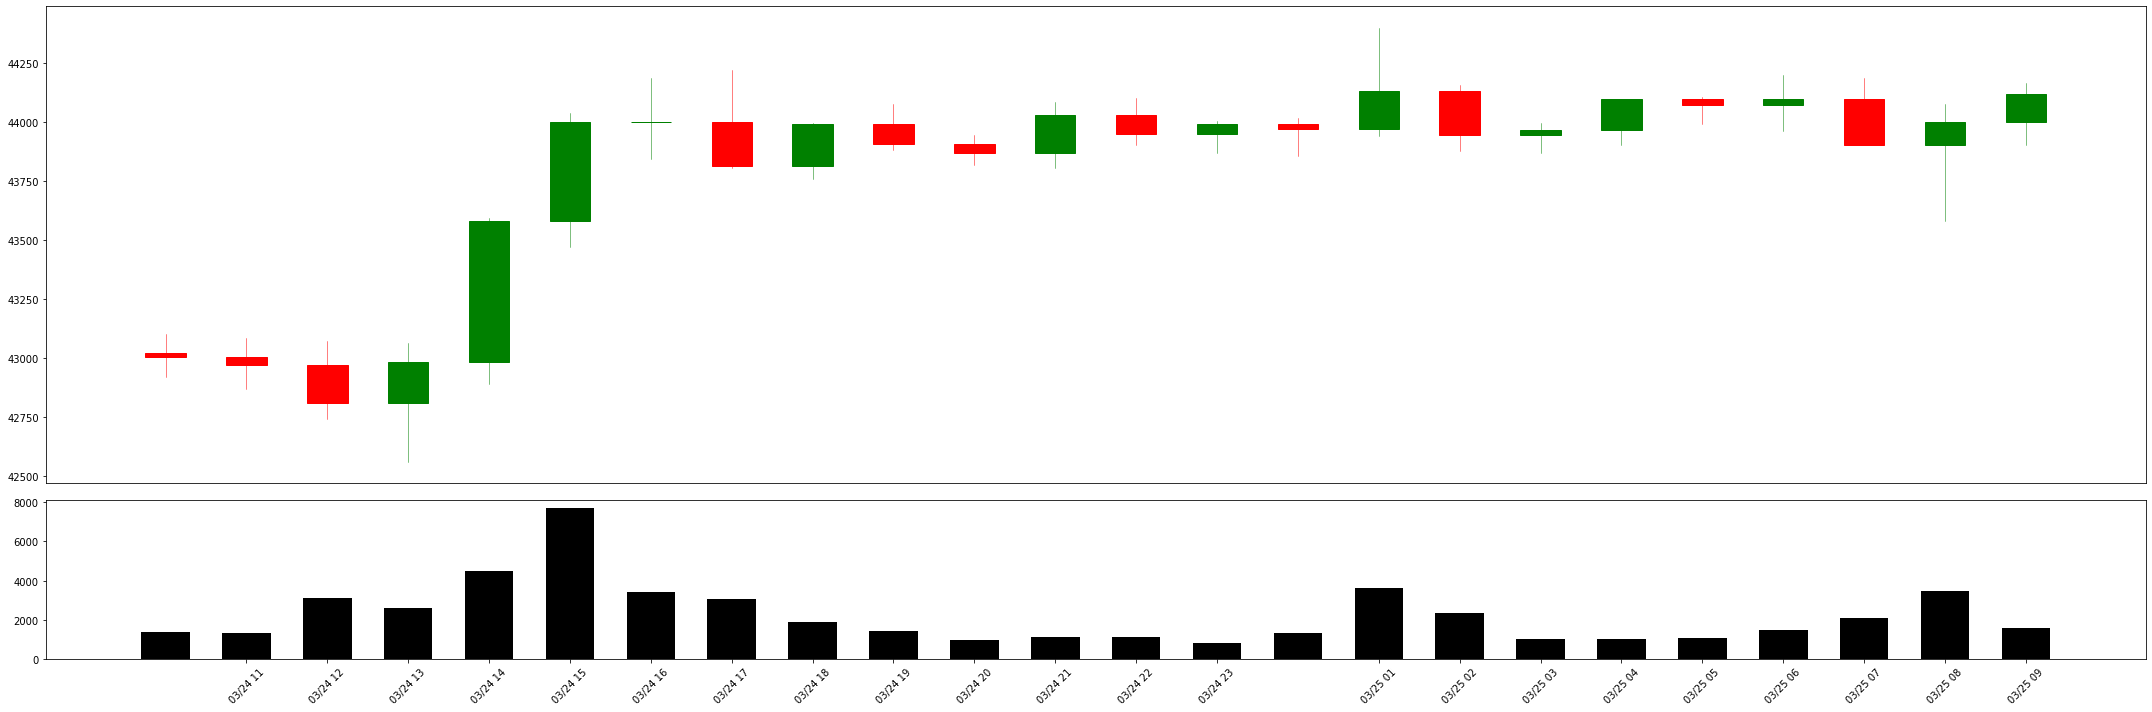

상하이 고등 법원 "비트코인은 재산, 재산권 보호 받아야" 판례 배포
상하이 고등 인민법원이 비트코인은 재산 속성의 자산으로 재산권의 보호를 받는다고 인정했다. 법원은 5일 공식홈페이지를 통해 '비트코인은 재산의 속성을 갖는가?'라는 제목의 판례 참고 문건을 게재, 이같이 밝혔다. 법원은 민사 소송 판례를 인용해 "비트코인은 가상 자산으로, 재산의 속성을 갖는다. 재산법권의 조정을 받는다. 법적 판단에 따라 비트코인을 반환하거나 지급하게 될 경우 집행법원은 물물 교부 청구권 규정으로 처리해야하며, 피집행자에게 집행가능한 비트코인이 없을 경우 양측이 합의해 양측이 인정하는 가격으로 보상하고, 합의가 이뤄지지 않을 경우 집행부에서 별도로 제소할 수 있다"고 진단했다. 앞서 지난해 8월 상하이 민항지방법원은 비트코인을 중국법의 보호를 받는 가상재산으로 간주해야 한다고 판결한 바 있다.
뉴스가 올라온 시각 : 2022년 5월 5일 23시 
딥러닝 기반 기사 유사도: 0.726
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:63.45%, 악재:2.82%, 중립:33.73%


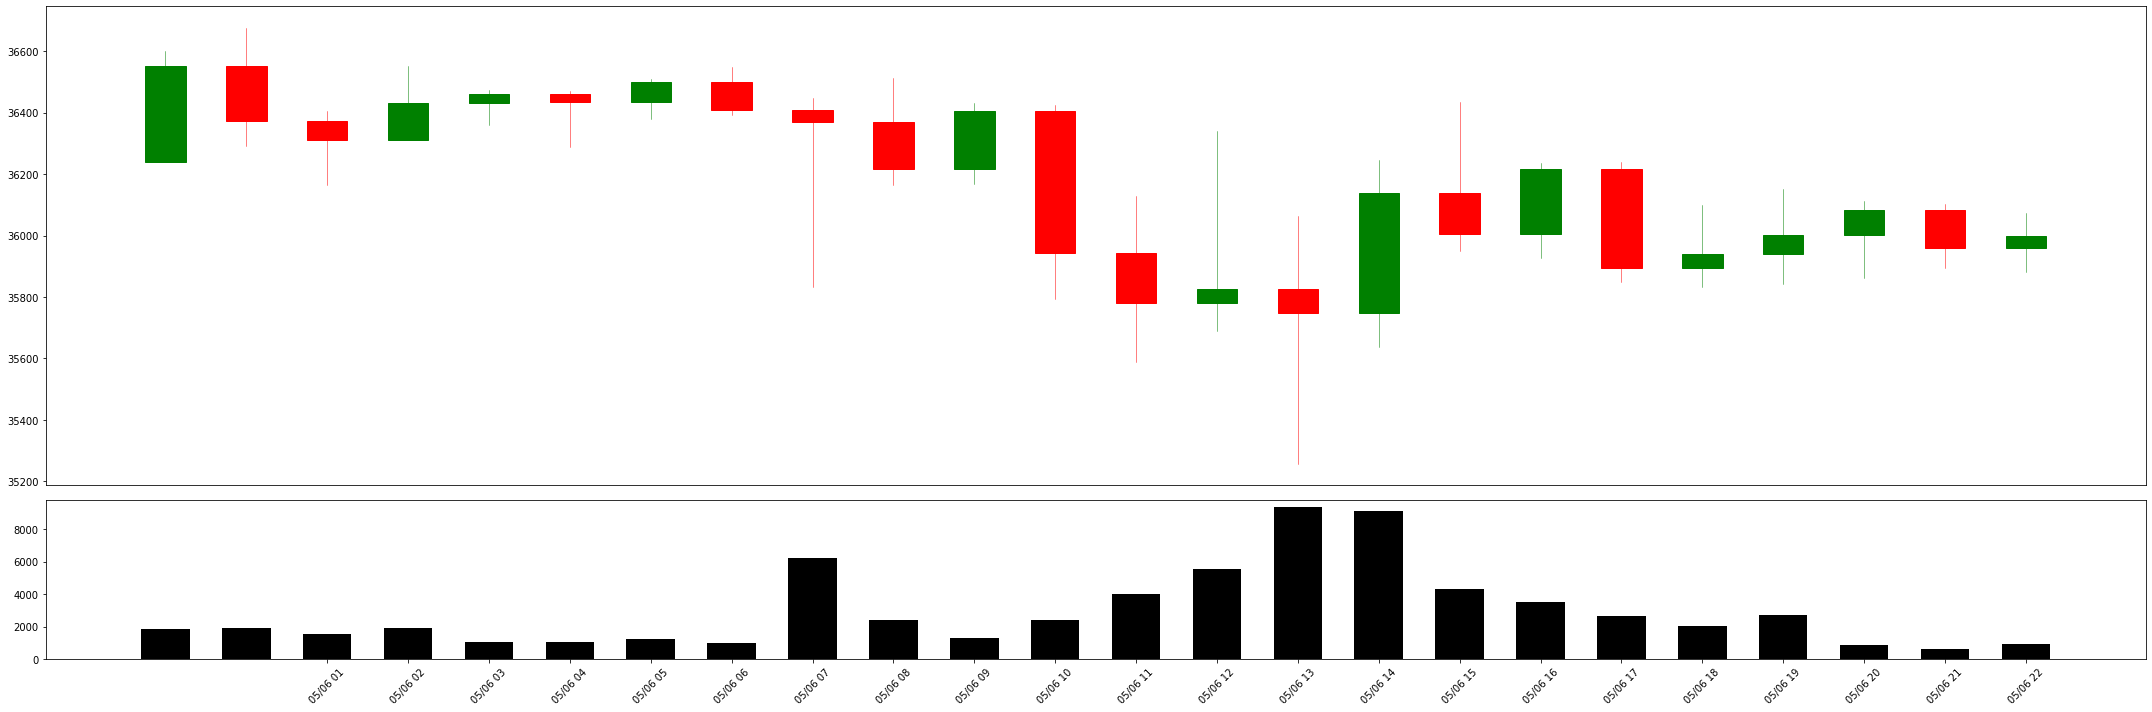

中 법원, "비트코인은 자산"…두 번째 판례
중국에서 암호화폐 비트코인을 자산으로 인정하는 판결이 나왔다.
코인텔레그래프 등 다수 외신은 19일(현지시간) 중국 항저우 인터넷 법원이 전날 열린 비트코인 재산권 침해를 둘러싼 소송에서 비트코인을 자산으로 인정하는 판결을 내렸다고 보도했다.
법원은 비트코인이 희소 가치 및 처분 가능성이 있기에 가상 자산으로 봐야 한다고 판단했다. 해당 소송은 파산한 암호화폐 거래소와 이용자 간의 분쟁 소송이었다.
해당 판결은 중국 법원이 암호화폐를 자산으로 인정한 두 번째 사례다. 앞서 선전 국제중재재판소는 지난해 10월 비트코인 관련 소송에서 비트코인을 자산으로 인정한 바 있다.
이번 판결은 선전 국제중재재판소 판례와 더불어 향후 비트코인 등 암호화폐 관련 분쟁을 해결하는 데 중요한 지표가 될 전망이다. 또한 이번 판결로 중국 내 암호화폐 관련 산업이 다시 활기를 띨 수 있을지 관심이 주목된다.
앞서 중국은 위안화 가치 하락을 방지하고, 사회 불안을 일으킬 수 있는 암호화폐 사기를 막기 위해 관련 산업을 전면 금지한 바 있다. 반면 최근 페이스북이 개발 중인 암호화폐 '리브라'에 가장 관심을 보인 국가는 중국으로 알려졌다.
검색어 데이터를 기반으로 대중의 관심 수준을 보여주는 구글트렌드에 따르면 중국은 지난 한 달간 '리브라’를 가장 많이 검색해, 검색어 관심도 최고 점수인 ‘100’을 기록했다.
뉴스가 올라온 시각 : 2019년 7월 22일 11시 
딥러닝 기반 기사 유사도: 0.7147
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:89.08%, 악재:2.24%, 중립:8.68%


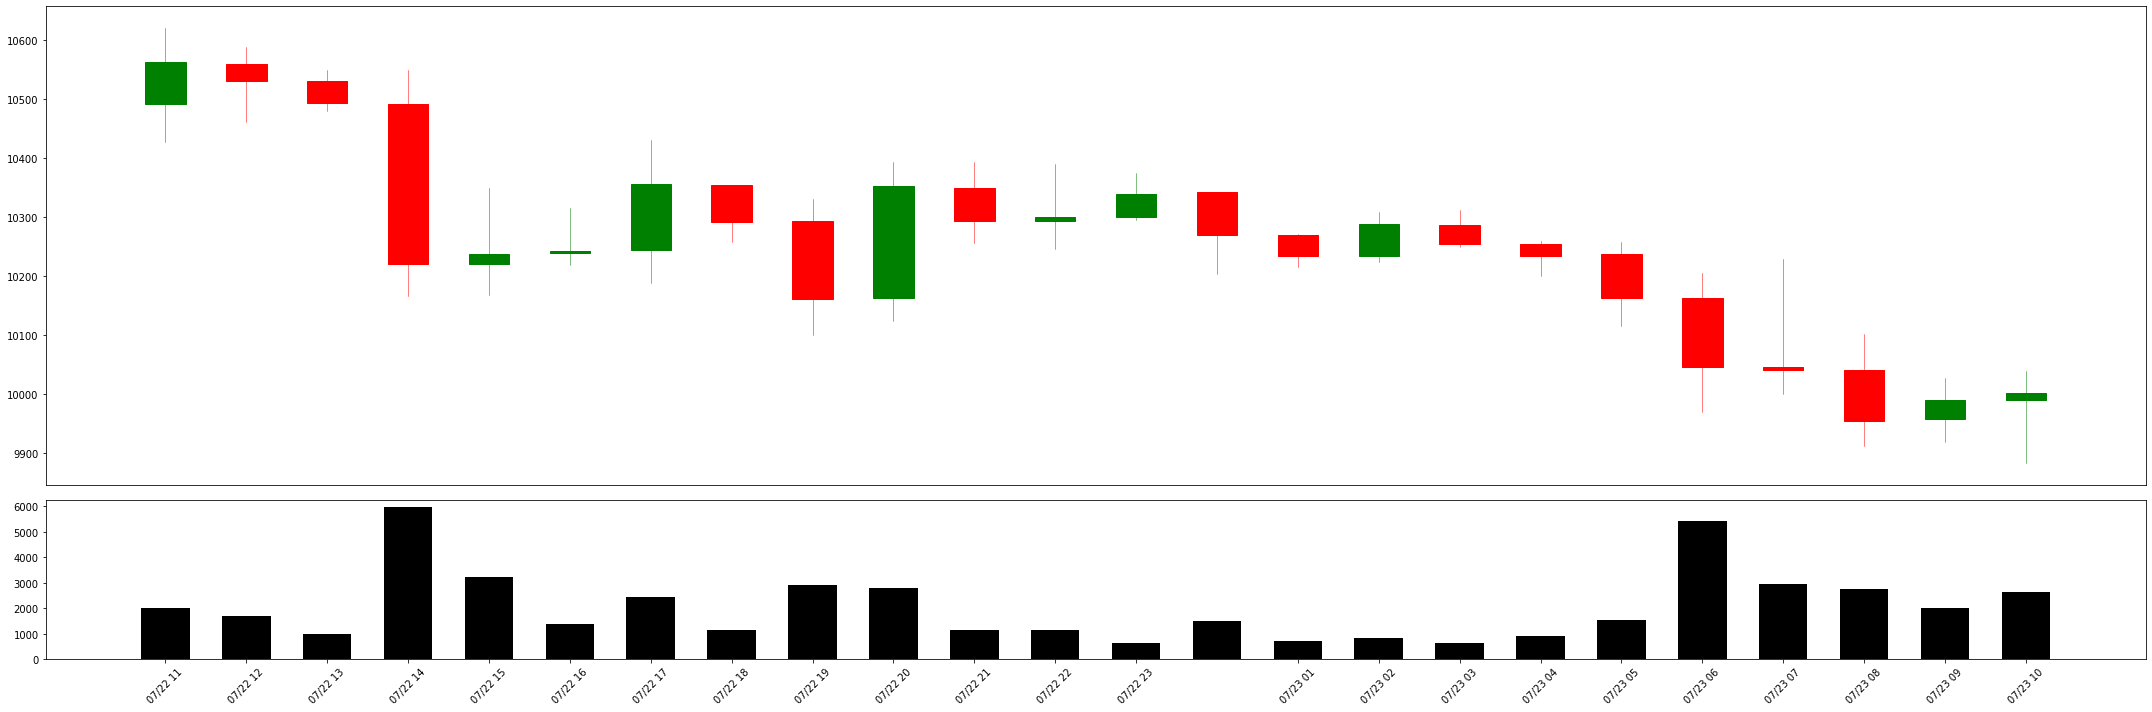

러시아 법원, 암호화폐 지불수단 인정 판결
비트코인닷컴에 따르면 러시아 상트페테부르크시 법원이 암호화폐를 지불 수단으로 인정한 것으로 알려졌다. 러시아인 2명이 100만 달러 규모의 암호화폐를 포함 약 109만 달러의 자산을 갈취한 혐의로 각각 9년, 7년형을 선고받으면서다. 해당 사건은 정부기관 요원을 사칭한 피고가 피해자를 협박해 암호화폐 등 자산을 갈취한 사건이다. 앞서 1심에서 법원은 암호화폐는 지불 수단이 아니라 소유권을 가질 수 없고, 범죄 대상으로 인정할 수 없다며 피고의 협박과 공갈혐의만 인정했었다. 이에 피해자와 검찰은 항소했고, 항소법원은 “암호화폐가 지불 수단으로 간주될 수 있다"며 1심으로 사건을 환송했다. 러시아 현지 매체는 "이번 판결이 향후 암호화폐를 어떤 기준으로 취급할지의 선례가 될 수 있다"고 진단했다.
뉴스가 올라온 시각 : 2022년 5월 25일 11시 
딥러닝 기반 기사 유사도: 0.7012
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:59.95%, 악재:2.65%, 중립:37.4%


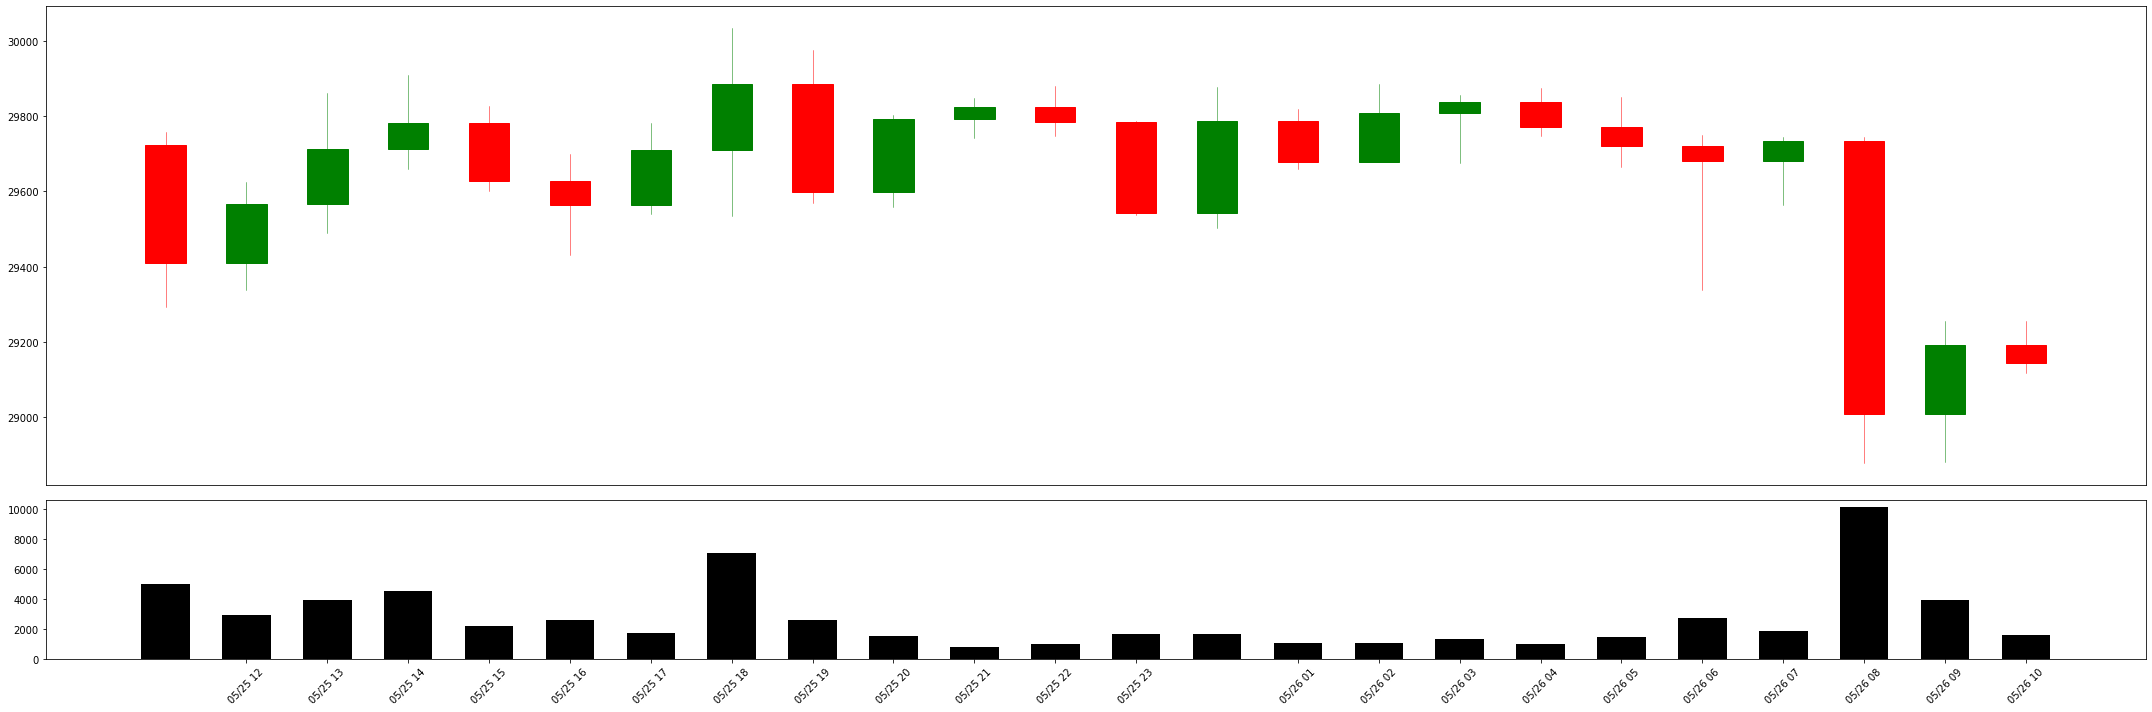

네덜란드 법원, “비트코인, 자산 특성 갖췄다” 판결
네덜란드 법원이 비트코인을 ‘양도가 가능한 가치’로 간주하는 판결을 내리면서 암호화폐의 주류 편입 가능성을 나타냈다. 22일 TNW의 보도에 따르면 네덜란드 법원이 비트코인 채무에 대한 판결을 내리는 과정에서 비트코인이 자산적 특성을 갖추고 있다고 인정했다. 암스테르담 지방 법원이 고객에게 채굴 수익 0.591비트코인을 지불하라는 법원의 명령을 이행하지 못한 개인기업 코인즈 트레이딩(KOINZ Trading BV)에 대해 20일 파산을 선언했다. 이 과정에서 법원은 “비트코인이 양도가 가능한 가치를 갖는 등 재산권의 특성을 갖추고 있다”고 밝혔다. 코인즈 트레이딩은 지난 1월 17일 하급 법원에서 해당 고객에 지급 명령을 받았으며 불이행 시 1만 유로의 벌금에 처한다고 선고를 받았다. 이후 명령 불이행으로 지난 2월 2일 법원에 고객의 탄원서가 제출됐으며 이에 2월 14일 불이행 시 파산 조건으로 지급 명령을 재 선고 받은 바 있다. 법원은 비트코인 지불을 요구하는 탄원 신청인의 손을 들어 주면서 “비트코인은 디지털 방식으로 암호화된 고유의 숫자 및 문자열이 권리자의 컴퓨터 하드 드라이브에 저장된 형태이다. 비트코인은 독립된 가치 파일이며 지불 처리 시 지급인으로부터 수취인에게로 직접 전달된다. 이는 비트코인이 가치를 가지며 양도가 가능하다는 것을 의미한다. 이러한 자산적 특성으로 인해 비트코인 지불 주장은 유효하다”고 설명했다. 한편 비트코인 지갑과 프라이빗 키 특성 상 파산 관재인이 기업의 암호화폐 자산을 몰수하거나 지급 명령을 이행할 방법은 불명확한 상황이다. 기업이 프라이빗 키를 제공하지 않을 경우 법원과 고객은 법정 화폐로 지급을 받을 수 밖에 없다.
뉴스가 올라온 시각 : 2018년 3월 23일 14시 
딥러닝 기반 기사 유사도: 0.6827
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:91.02%, 악재:0.49%, 중립:8.49%


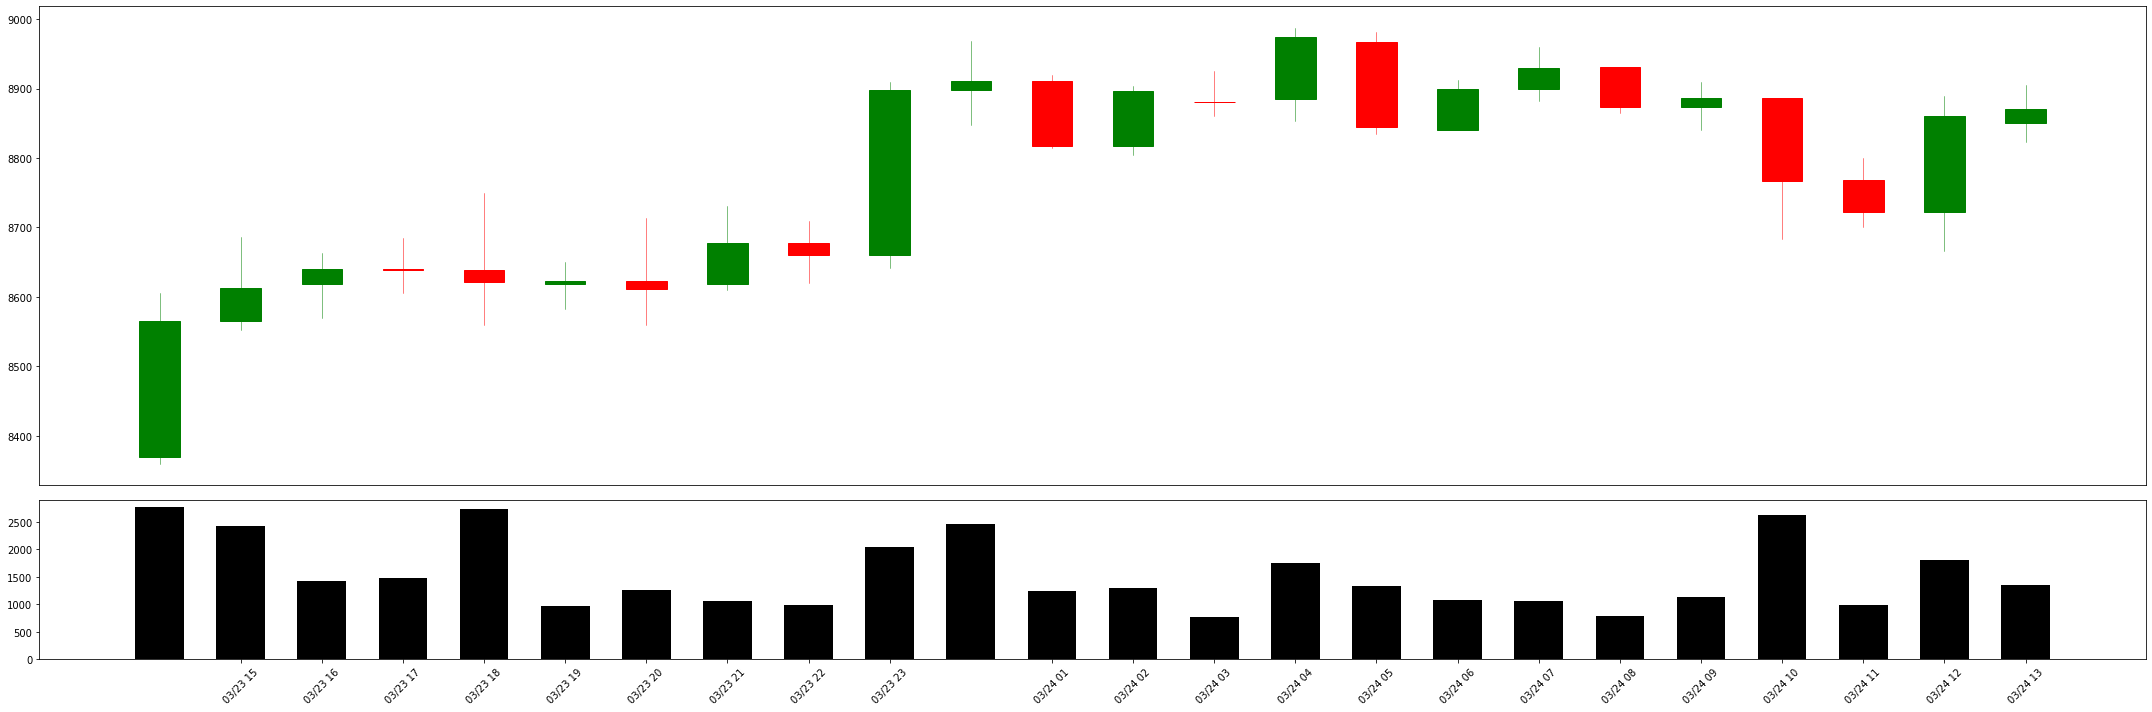

中 국제중재재판소 비트코인 '자산' 판결…합법 결제수단 인정될까
중국 선전의 국제 중재 재판소가 비트코인에 대해 정부 입장과 상반된 판결을 내놓으면서, 비트코인이 합법적인 결제 수단으로 인정 받을 수 있다는 기대가 점차 커지고 있다.
28일(현지시간) 비트코인익스체인지가이드 보도에 따르면, 중국 선전 국제 중재 재판소는 "비트코인이 디지털 화폐가 아니라 자산 또는 재산으로 간주된다"고 판결했다.
해당 판결에 따르면, 비트코인은 다른 자산과 마찬가지로 개인 또는 기관의 보유‧거래‧양도가 가능해지며, 화폐에 적용되는 금융법과 규제에 상충되지 않는다.
판결을 통해, 엄격한 제재 조치 아래 있는 암호화폐 시장이 새로운 전기를 맞게 될지 귀추가 주목되고 있다. 비트코인을 화폐로 공표한 것은 아니나 다른 자산과 동일한 권리와 보호를 확보하게 됐다. 자산 거래가 합법이기 때문에 결제 또한 가능해진다.
공개된 문건은 "비트코인은 자산의 특성을 가진다. 소유인이 이를 관리할 수 있고, 그 경제적 가치는 소유인에게 귀속된다. 이는 법에 위배되지 않는다"고 재판소의 입장을 기록하고 있다.
암호화폐 연구가인 캐서린 우(Katherine Wu)는 "중재 재판소는 비트코인의 적법성 여부와 상관 없이 비트코인의 유통과 지불을 불법이 아닌 것으로 보고 있다. 때문에 비트코인은 법정화폐와 동일한 지위를 가지며, 암호화폐 보유와 결제 또한 불법이 아니다"라고 설명했다.
중국은 이미 현금 결제를 거의 진행하지 않는다. 작은 매장도 텐센트의 위페이와 같은 앱을 통해 결제를 진행한다.
한편, 중국 재판소가 비트코인의 보유와 양도를 합법적 행위로 판결했기 때문에 법에 저촉될 위험 없이 더 저렴하고 빠른 암호화폐 결제를 도입할 수 있다.
9월 말, 베이징의 중국의 유명 과학 기술 잡지 '베이징사이언스테크리포트(BSTR)'는 연간 구독료를 비트코인으로 결제할 수 있도록 하고 있다. 출판사는 블록체인 기술을 촉진하고, 암호화폐 의 실용성을 보여주기 위함이라고 전했다. BSTR은 0.01BTC로 약 7만원

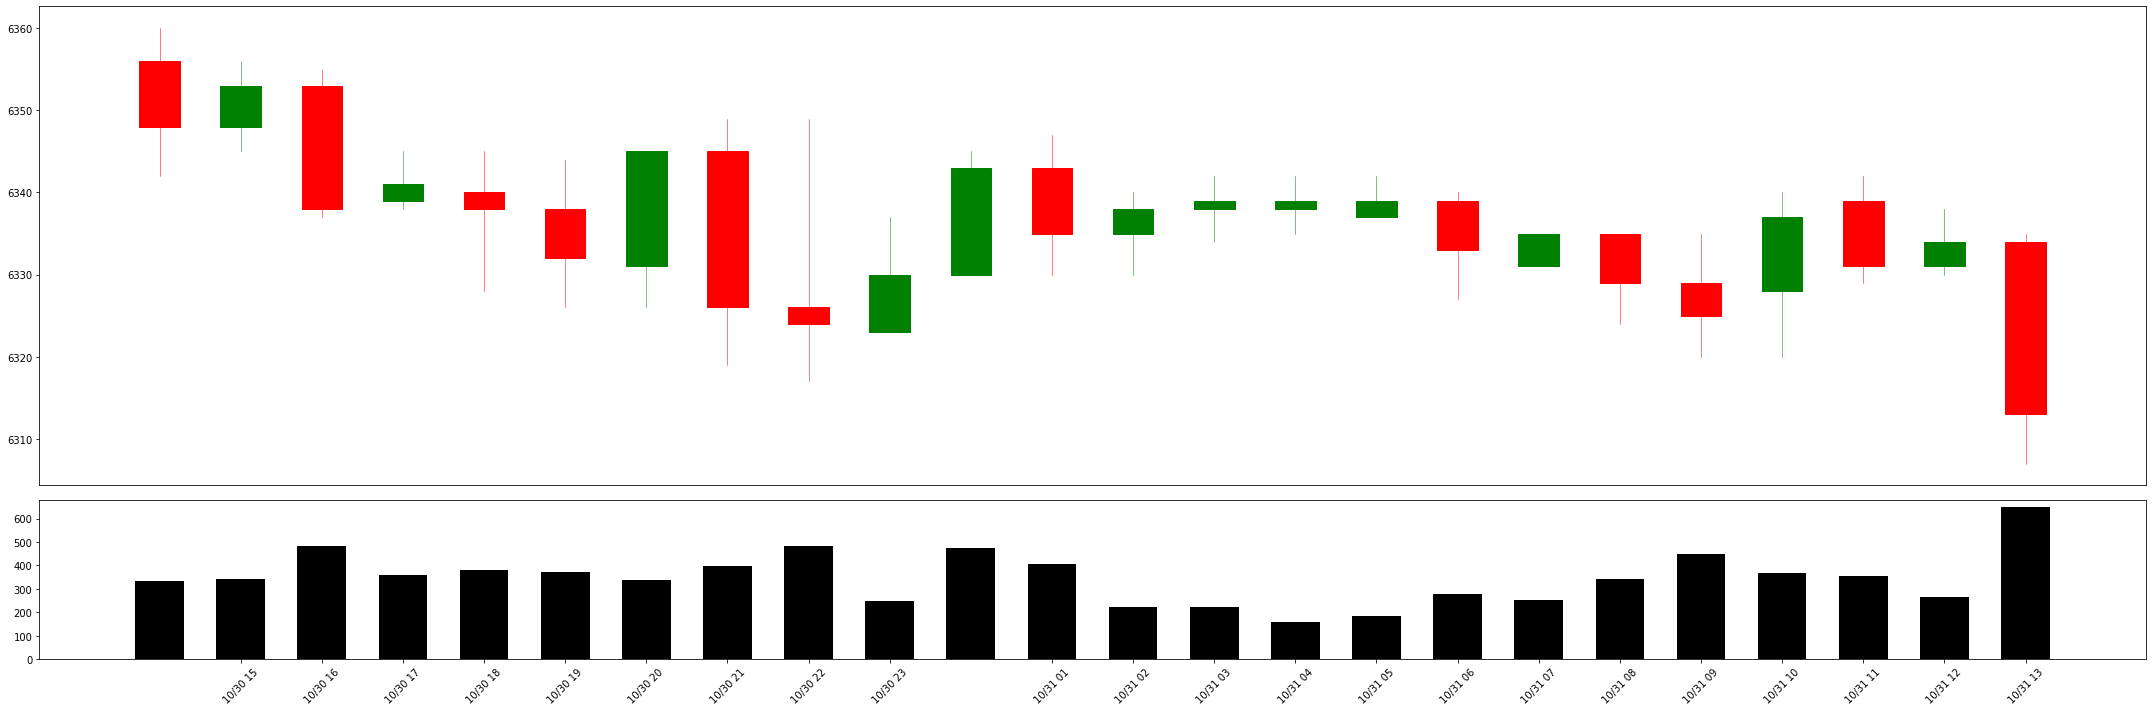

中 상하이 법원 "비트코인은 중국법 보호 받는 가상재산"
유투데이에 따르면, 상하이 민항지방법원이 비트코인을 중국법의 보호를 받는 가상재산으로 간주해야 한다고 판결했다. 원고는 피고로부터 비트코인 채굴기 구입 후 당국의 비트코인 단속으로 환불을 요청했으나, 법원은 비트코인이 가상재산이기 때문에 해당 구매계약이 유효하다고 보고 원고 요청을 기각했다. 법원은 또 암호화폐의 다양한 사례를 가상재산으로 분류했으며, 취득 시 전력과 생산설비 등 일정 자원이 필요한 비트코인을 '특수 가상화폐'로 꼽았다.
뉴스가 올라온 시각 : 2021년 8월 18일 19시 
딥러닝 기반 기사 유사도: 0.6544
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:57.58%, 악재:18.17%, 중립:24.26%


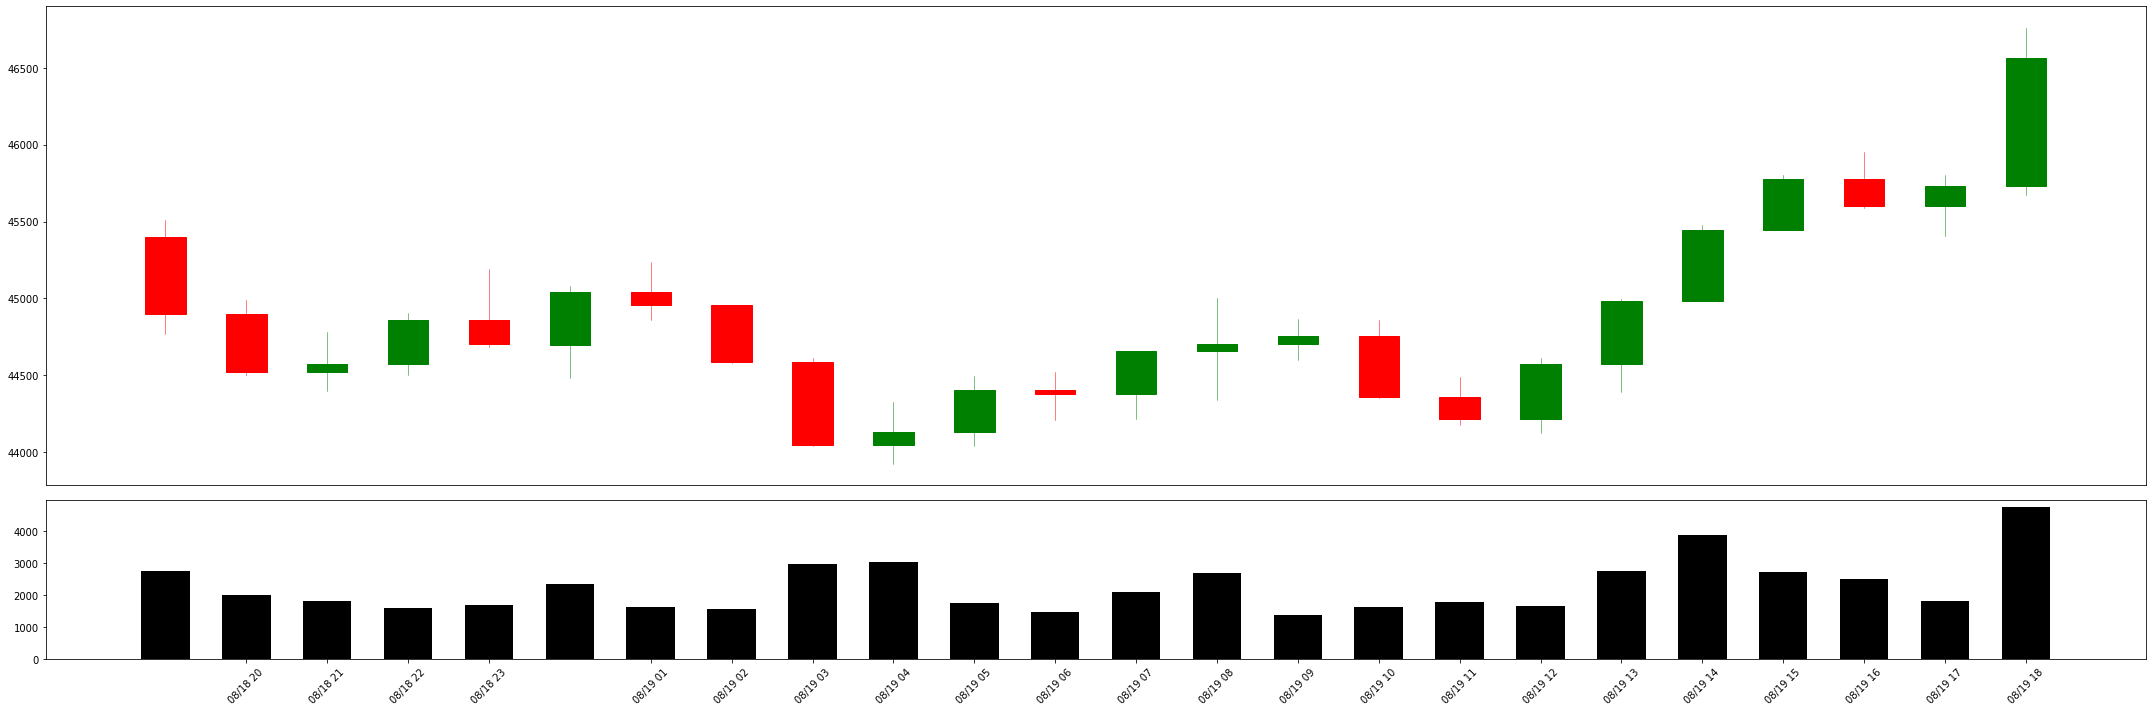

[대법 "비트코인도 사기죄 객체인 재산상 이익"..보스코인 유죄 확정]
비트코인도 사기죄의 객체인 재산상 이익에 해당한다는 대법원 판결이 나왔다고 뉴스1이 보도했다. 대법원 3부(주심 김재형 대법관)는 특정경제범죄가중처벌등에관한법률위반(사기) 혐의로 기소된 보스코인 박모씨에게 징역 2년6개월에 집행유예 3년을 선고한 원심을 확정했다고 19일 밝혔다. 이와 관련해 대법원은 대법원도 "비트코인은 경제적인 가치를 디지털로 표상해 전자적으로 이전, 저장과 거래가 가능하도록 한 가상자산의 일종으로 사기죄의 객체인 재산상 이익에 해당한다"며 원심 판결을 확정했다. 박씨는 항소심에서 "비트코인의 전송은 '정보의 기록이나 변경'에 불과하므로 이를 재산상 이익의 이전이라고 볼 수 없다"며 "사기죄에서 말하는 처분행위가 있었다고 볼 수 없다"고 주장한 바 있다. 박씨는 회사의 설립자인 아버지가 다른 임원들과 갈등을 겪던 중, 주요주주 A씨 등에게 "다중서명계좌에 보관된 비트코인 중 6000BTC을 내 단독 명의 계좌로 이체시켜주면 코인이벤트에 참가한 후 곧바로 반환하겠다"고 속여 비트코인을 단독계좌로 이체받고 반환하지 않은 혐의로 기소됐다. 1심 법원은 박씨가 비트코인을 이체받아 이를 가지고 아버지의 회사에서의 지배력 강화 또는 갈등 해결 과정에서 유리한 조건을 획득할 목적으로 범행을 저질렀다고 봤다.
뉴스가 올라온 시각 : 2021년 11월 19일 8시 
딥러닝 기반 기사 유사도: 0.6529
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:7.23%, 악재:17.27%, 중립:75.51%


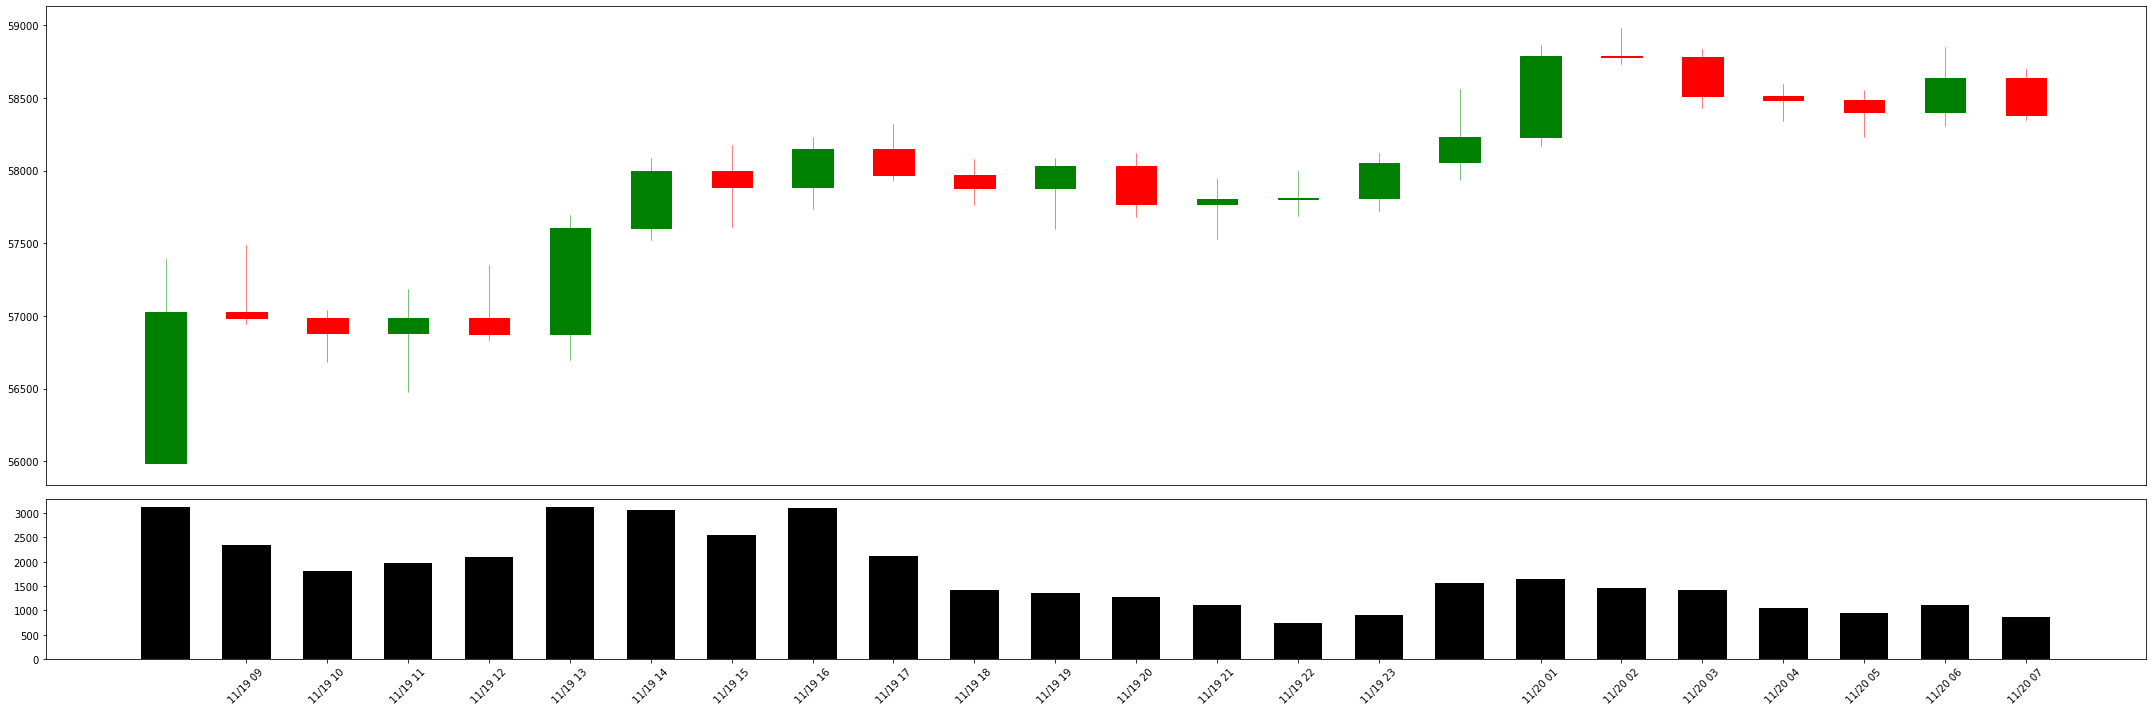

"파산 선고일 시세로 '코인' 계산"…가이드라인 나왔다
한국경제에 따르면 암호화폐를 보유한 법인·개인이 파산할 때 파산선고일 기준 전후 1개월의 평균가로 암호화폐의 가치를 평가하는 것이 적절하다는 법원의 가이드라인이 처음 제시됐다. 서울회생법원 가상자산연구반은 파산 시 암호화폐의 가치 평가 기준 등이 포함된 가이드라인을 제작해 배포한 것으로 알려졌다. 가이드라인에 따르면 법원은 법인이 가상화폐 등을 보유한 경우, 이를 자산으로 평가해 회생·파산 선고 등에 활용할 필요가 있다고 판단했다. 특히 법인 파산 선고시 가상거래소의 시세를 기준으로 평가하는 것이 바람직하다는 의견을 내놨다. 다만 거래소에 상장되지 않은 가상화폐 등의 경우는 대학, 가상화폐 협회, 전문가 단체 등 이해관계가 없는 전문가들의 시가감정촉탁을 받아 가치를 평가 받는 방법을 고려 중이다. 반면 개인파산 시에는 가상화폐가 파산 원인에 영향을 미쳤는지, 개인이 해당 자산에 대한 면책 신청을 했는지 등을 종합적으로 고려해 자산을 평가할 예정이다. 다만 가상화폐의 가격이 시시각각 변하는 만큼, 각 기준일 전후 1개월 동안의 평균가액으로 가치를 산정할 것으로 보인다. 이는 상속세 및 증여세법(상증세법)상 가상화폐를 평가하는 방법을 참고한 것이다.
뉴스가 올라온 시각 : 2022년 6월 3일 19시 
딥러닝 기반 기사 유사도: 0.6472
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:26.42%, 악재:7.7%, 중립:65.88%


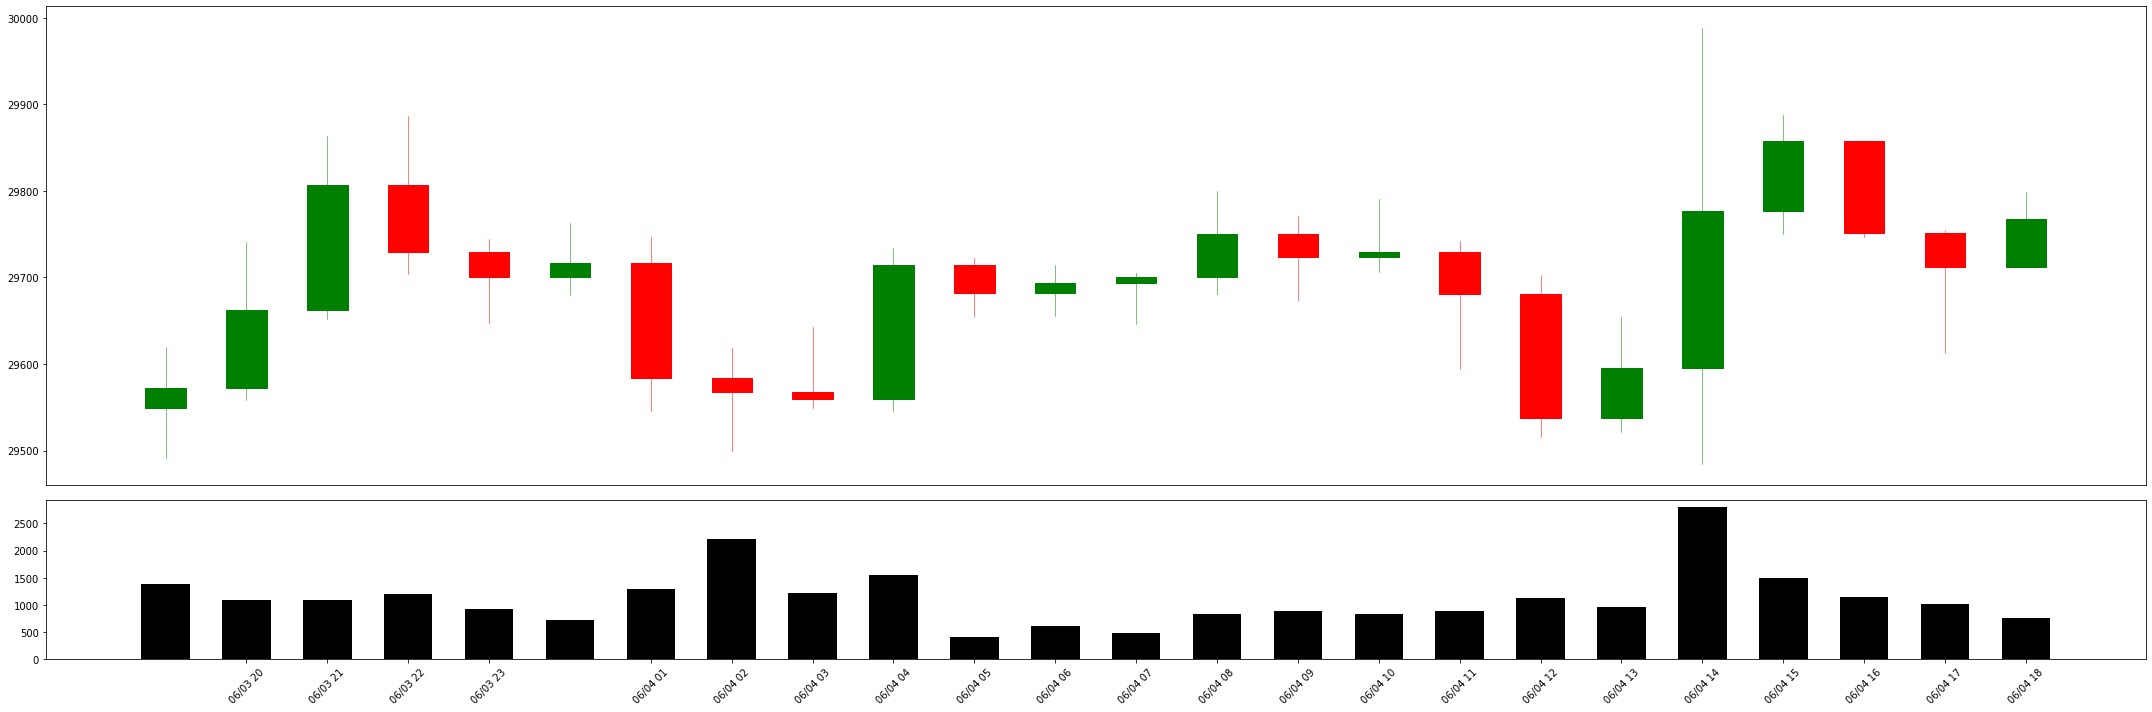

이스라엘 법원, “비트코인은 자산, 소득세 납부해야”
이스라엘 법원이 비트코인을 화폐가 아니라 자산이기 때문에 양도 소득세를 부과해야 한다고 판결했다.
22일(현지시간) 코인데스크 보도에 따르면 이스라엘 중앙법원은 블록체인 스타트업 DAV네트워크 창립자 노암 카펠(Noam Copel)과 국세청 간 소송에 이같이 판결했다.
노암 카펠은 2011년 비트코인을 매입하고, 2013년 이를 처분하며 229만 달러 상당의 이득을 남겼다. 그는 소송 과정에서 비트코인을 외화로 보고 과세하지 않아야 한다고 주장해왔다.
반대로 국세청은 비트코인을 화폐가 아닌 자산으로 간주하며 관련 소득에 양도 소득세를 부과해야 한다고 주장했다.
슈무엘 본스타인(Shmuel Bornstein) 재판장은 비트코인이 사라질 수 있고 다른 암호화폐로 대체될 수 있다는 점을 강조하며, 과세 측면에서 비트코인을 화폐로 볼 수 없다고 판결했다.
이스라엘 정부도 비트코인을 비롯한 기타 암호화폐를 과세 자산으로 간주한다는 입장을 같이하고 있다.
판결에 따라 노암 카펠은 세금 약 83만 600달러와 비용 8306달러를 납부해야 한다. 판결을 뒤집기 위해 대법원에 항고할 수 있다.
국세청은 지난해 2월 암호화폐 소득이 양도 소득세 대상이며 20~25% 세율을 부과하겠다고 발표한 바 있다. 개인적인 암호화폐 채굴이나 사업과 연결되는 거래는 양도소득세뿐 아니라 17%의 부가가치세도 추가 납부해야 한다.
뉴스가 올라온 시각 : 2019년 5월 23일 10시 
딥러닝 기반 기사 유사도: 0.6451
비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:24.36%, 악재:39.2%, 중립:36.44%


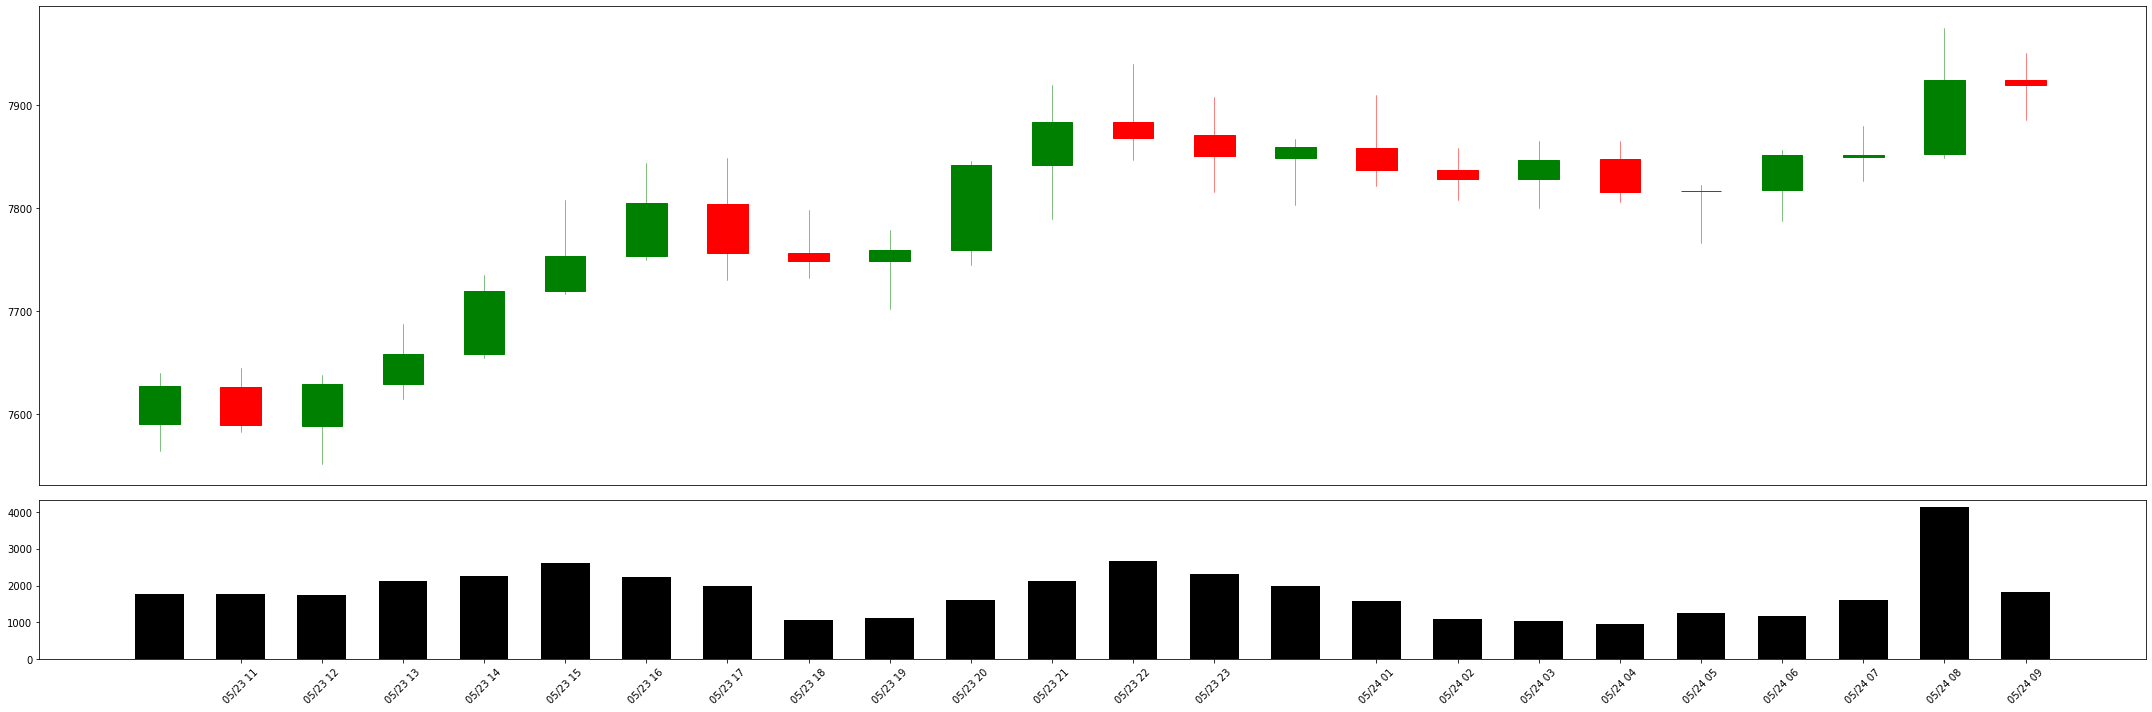

In [53]:
# ranking with chart information 

print("{}개의 DB에 저장된 후보 뉴스중 쿼리 코인니스 뉴스와 가장 유사한 top 10개의 코인니스 뉴스를 유사도 기반으로 랭킹해서 보여줍니다.".format(df.shape[0])) 

q_id = 5

query = torch.reshape(candidates[q_id],(-1,768))  
query_year = years[q_id] 
query_month = months[q_id] 
query_day = days[q_id] 
query_hour = hours[q_id] 

lookahead_window = 24 # look ahead for the next 24 hours since the news was posted 
linebreaks = 5 

def plot_chart(sample_df): 
    fig = plt.figure(figsize=(30,10)) 
    fig.set_facecolor("w") 
    gs = gridspec.GridSpec(2, 1, height_ratios=[3,1]) 
    axes = [] 
    axes.append(plt.subplot(gs[0])) 
    axes.append(plt.subplot(gs[1], sharex=axes[0])) 
    axes[0].get_xaxis().set_visible(False)
    x = np.arange(len(sample_df.index))
    ohlc = sample_df[["open","high","low","close"]].astype(int).values 
    dohlc = np.hstack((np.reshape(x, (-1,1)), ohlc)) 

    candlestick_ohlc(axes[0], dohlc, width=0.5, colorup="g", colordown="r") 

    axes[1].bar(x, sample_df.volume, color="k", width=0.6, align="center") 
    _xticks = [] 
    _xlabels = [] 
    _wd_prev = 0 
    for _x, d in zip(x, sample_df.datetime.values): 
        weekday = datetime.datetime.strptime(str(d), "%Y-%m-%d %H:%M:%S").weekday() 
        if weekday <= _wd_prev: 
            _xticks.append(_x) 
            _xlabels.append(datetime.datetime.strptime(str(d), "%Y-%m-%d %H:%M:%S").strftime("%m/%d %H")) 
        _wd_prev = weekday 
    axes[1].set_xticks(_xticks) 
    axes[1].set_xticklabels(_xlabels, rotation=45, minor=False) 
    plt.tight_layout() 
    
    plt.show(block=True) 

sim_scores = cdist(query, candidates, "cosine")[0]

print("="*30 + " " + "query" + " " + "="*30) 
print(titles[q_id]) 
print(contents[q_id]) 
datestr = str(query_year) + "년 " + str(query_month) + "월 " + str(query_day) + "일 " + str(query_hour) + "시 " 
print(f"뉴스가 올라온 시각 : {datestr}") 
sentiment_score = get_sentiment_score(str(titles[q_id]), str(contents[q_id]))  
print(f"비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:{round(sentiment_score[0].item()*100,2)}%, 악재:{round(sentiment_score[1].item()*100,2)}%, 중립:{round(sentiment_score[2].item()*100,2)}%")

for i in range(len(years)):
    if chart_years[i] == query_year and chart_months[i] == query_month and chart_days[i] == query_day and chart_hours[i] == query_hour:
        open_list = open_vals[i:i+lookahead_window] 
        high_list = high_vals[i:i+lookahead_window] 
        low_list = low_vals[i:i+lookahead_window]  
        close_list = close_vals[i:i+lookahead_window] 
        volume_list = volume[i:i+lookahead_window] 
        datetime_list = datetimes[i:i+lookahead_window] 
        cur_df = pd.DataFrame(list(zip(open_list, high_list, low_list, close_list, volume_list, datetime_list)), columns=["open", "high", "low", "close", "volume", "datetime"])        
        plot_chart(cur_df)
        break 

for i in range(linebreaks):
    print() 
    

topk, cnt = 10, 0 
ranks = np.argsort(sim_scores) 
print("="*30 + " " + "candidates" + " " + "="*30) 
for i in range(len(ranks)):
    if q_id == ranks[i]:
        continue 
    else: 
        print(titles[ranks[i]]) 
        print(contents[ranks[i]]) 
        datestr = str(years[ranks[i]]) + "년 " + str(months[ranks[i]]) + "월 " + str(days[ranks[i]]) + "일 " + str(hours[ranks[i]]) + "시 " 
        print(f"뉴스가 올라온 시각 : {datestr}") 
        print(f"딥러닝 기반 기사 유사도: {round(1 - sim_scores[ranks[i]], 4)}") 
        sentiment_score = get_sentiment_score(str(titles[ranks[i]]), str(contents[ranks[i]]))
        print(f"비트코인 가격에 대한 딥러닝 기반 감성 분석 - 호재:{round(sentiment_score[0].item()*100,2)}%, 악재:{round(sentiment_score[1].item()*100,2)}%, 중립:{round(sentiment_score[2].item()*100,2)}%")
        for j in range(len(years)): 
            if chart_years[j] == years[ranks[i]] and chart_months[j] == months[ranks[i]] and chart_days[j] == days[ranks[i]] and chart_hours[j] == hours[ranks[i]]:
                open_list = open_vals[j:j+lookahead_window] 
                high_list = high_vals[j:j+lookahead_window] 
                low_list = low_vals[j:j+lookahead_window] 
                close_list = close_vals[j:j+lookahead_window] 
                volume_list = volume[j:j+lookahead_window] 
                datetime_list = datetimes[j:j+lookahead_window] 
                cur_df = pd.DataFrame(list(zip(open_list, high_list, low_list, close_list, volume_list, datetime_list)), columns=["open", "high", "low", "close", "volume", "datetime"])
                plot_chart(cur_df) 
                break  
        
        print("="*200) 
        cnt += 1 
    if cnt == topk: 
        break 
